# **Proyek 2: Time Series**

### Nico Marcelino

# Downloading Data

In [78]:
# install package and upload API key
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"helixneek","key":"dcfc8fada4acacb6f21efd5d5de301be"}'}

In [79]:
# change permissions and make directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [80]:
# download and unzip file
!kaggle datasets download -d arashnic/learn-time-series-forecasting-from-gold-price

!mkdir learn-time-series-forecasting-from-gold-price.zip
!unzip learn-time-series-forecasting-from-gold-price.zip -d learn-time-series-forecasting-from-gold-price
!ls learn-time-series-forecasting-from-gold-price

learn-time-series-forecasting-from-gold-price.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘learn-time-series-forecasting-from-gold-price.zip’: File exists
Archive:  learn-time-series-forecasting-from-gold-price.zip
replace learn-time-series-forecasting-from-gold-price/gold_price_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: learn-time-series-forecasting-from-gold-price/gold_price_data.csv  
gold_price_data.csv


# Preparing Dataset

In [333]:
# import libraries
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [334]:
# make dataframe
df = pd.read_csv('learn-time-series-forecasting-from-gold-price/gold_price_data.csv')
df

,Date,Value
0,1970-01-01,35.20
1,1970-04-01,35.10
2,1970-07-01,35.40
3,1970-10-01,36.20
4,1971-01-01,37.40
...,...,...
10782,2020-03-09,1672.50
10783,2020-03-10,1655.70
10784,2020-03-11,1653.75
10785,2020-03-12,1570.70


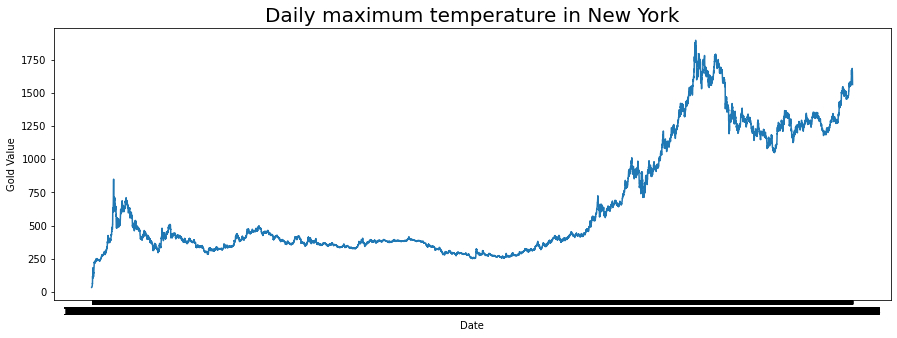

In [335]:
# get values from dataframe and making plot
dates = df['Date'].values
gold  = df['Value'].values

plt.figure(figsize=(15,5))
plt.plot(dates, gold)
plt.xlabel('Date')
plt.ylabel('Gold Value')
plt.title('Daily maximum temperature in New York', fontsize=20);

In [336]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dates, gold, test_size=0.2, random_state=0, shuffle=False)

In [337]:
# making training dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
        series = tf.expand_dims(series, axis=-1)
        ds = tf.data.Dataset.from_tensor_slices(series)
        ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
        ds = ds.flat_map(lambda w: w.batch(window_size + 1))
        ds = ds.shuffle(shuffle_buffer)
        ds = ds.map(lambda w: (w[:-1], w[-1:]))
        return ds.batch(batch_size).prefetch(1)

In [338]:
# making the model
train_set = windowed_dataset(y_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(y_test, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(128, return_sequences=True),
      tf.keras.layers.LSTM(64, return_sequences=True),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(30, activation='relu'),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 400),
    ])

In [339]:
# counting how much MAE is wanted
threshold_mae = (df['Value'].max() - df['Value'].min()) * 10/100
threshold_mae

185.99

In [340]:
class myCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
        if(logs.get('mae') < threshold_mae and logs.get('val_mae') < threshold_mae):
          print("\nMAE has reached <10%!")
          self.model.stop_training = True
callbacks = myCallback()

In [341]:
# compiling and fitting model
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**5)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
epochs = 100

model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

history = model.fit(train_set, epochs=epochs, callbacks=[callbacks], validation_data=test_set)

Epoch 1/100
86/86 [==============================] - 34s 352ms/step - loss: 178.3022 - mae: 178.8012 - val_loss: 637.3443 - val_mae: 637.8443
Epoch 2/100
86/86 [==============================] - 27s 317ms/step - loss: 171.2833 - mae: 171.7823 - val_loss: 661.6496 - val_mae: 662.1496
Epoch 3/100
86/86 [==============================] - 27s 317ms/step - loss: 135.8862 - mae: 136.3849 - val_loss: 554.8337 - val_mae: 555.3337
Epoch 4/100
86/86 [==============================] - 27s 316ms/step - loss: 124.8476 - mae: 125.3462 - val_loss: 477.5791 - val_mae: 478.0791
Epoch 5/100
86/86 [==============================] - 27s 315ms/step - loss: 101.8524 - mae: 102.3508 - val_loss: 353.5779 - val_mae: 354.0779
Epoch 6/100
86/86 [==============================] - 27s 317ms/step - loss: 79.0600 - mae: 79.5581 - val_loss: 219.9858 - val_mae: 220.4854
Epoch 7/100
86/86 [==============================] - ETA: 0s - loss: 61.3650 - mae: 61.8626
MAE has reached <10%!
86/86 [=============================

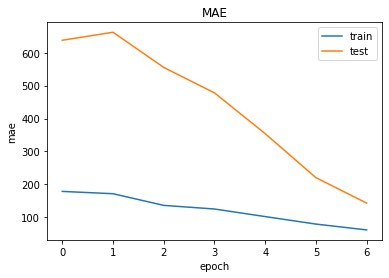

In [342]:
# plot of mae
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

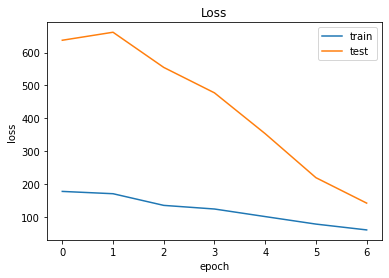

In [343]:
# plot of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()